In [1]:
import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial as fac


In [2]:
"""Define the operators for MZI - we will deal in Heisenberg """
T = Symbol('T')
xvec = np.arange(-40.,40.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
X1,Y1 = np.meshgrid(yvec,yvec)
N_dim = 35##Dimenstion of the Hilbert spac

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return fac(n)/(fac(n-k)*fac(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def sq_tri_cat(r,amp):
    state=ket2dm((displace(N_dim,amp)*squeeze(N_dim,r)*fock(N_dim,0)+displace(N_dim,amp*np.e**(2j*np.pi/3))*squeeze(N_dim,r*np.e**(4j*np.pi/3))*fock(N_dim,0)+displace(N_dim,amp*np.e**(4j*np.pi/3))*squeeze(N_dim,r*np.e**(2j*np.pi/3))*fock(N_dim,0)))
    norm_state=state/state.tr()
    return norm_state
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def catalysis(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F
def catalysis_temp(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(qeye(N_dim),pnr_resolution_detector(eta, num_det, n_truc));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(0))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered


The probability of a sucessful detection is: 0.46251956708350156
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000174FFC71048> > state, where my detector has efficiency 1


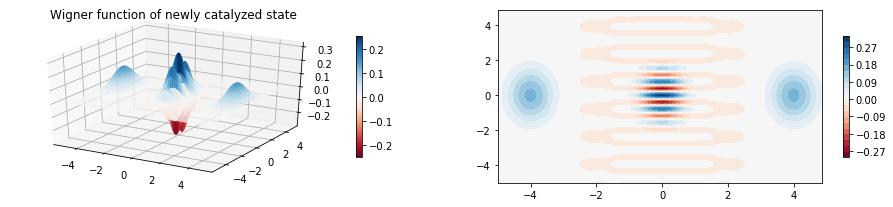

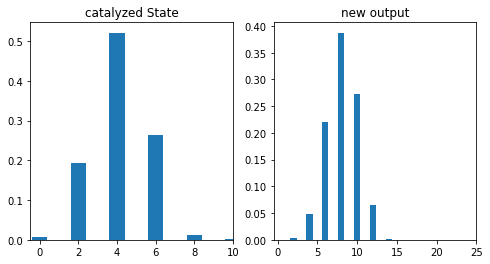

In [3]:
'''state with two squeezed cat states, and send to a balanced beamsplitter.  Then perform a 
PNR detection of n=0 photons on one output.  The remaining output is an enlarged squeezed cat'''
eta=1; 
sq=.4
amp=2
state1=SSV_plus(sq,amp) #squeezed cat state
output=catalysis(state1,state1,1/2,0,eta,N_dim)

W_out=wigner(output,xvec,xvec)

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
bar0 = axes[0].bar(range(N_dim), state1.diag())

lbl0 = axes[0].set_title("catalyzed State")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), output.diag())

lbl1 = axes[1].set_title("new output")

lim1 = axes[1].set_xlim([-.5, 25])


plt.show()

The probability of a sucessful detection is: 0.3049323037193443
BS has reflectivity 0.5  and I am detecting the | <function num at 0x00000174FFC71048> > state, where my detector has efficiency 1
Mean photon number of starting state is 14.058714453910035
Mean photon number of end state is 27.524671536402284
fidelity of output 0.9811468046765948


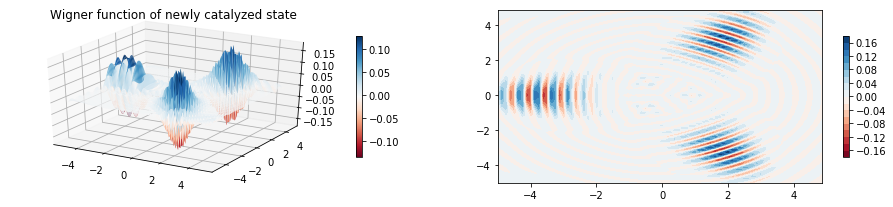

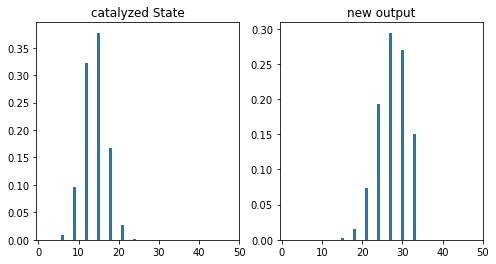

In [4]:
'''Do the same as before, but with an M=3 symmetry SSV state (e.g. mix at beamsplitter and do a PNR detection
of n=0)'''
sq=0.24
amp=np.sqrt(14)
state2=sq_tri_cat(sq,amp)
output=catalysis(state2,state2,1/2,0,eta,N_dim)

W_out=wigner(output,xvec,xvec)

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
fid=fidelity(output,sq_tri_cat(sq,amp*np.sqrt(2)))
print('fidelity of output',fid)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
bar0 = axes[0].bar(range(N_dim), state2.diag())

lbl0 = axes[0].set_title("catalyzed M=3 SSV State")

lim0 = axes[0].set_xlim([-.5, 50])
bar1 = axes[1].bar(range(N_dim), output.diag())

lbl1 = axes[1].set_title("new output - enlarged SSV")

lim1 = axes[1].set_xlim([-.5, 50])


plt.show()

In [60]:
#test loop
successprob=np.zeros((10,12))
x=0
for k in range(10):
    x=k
    F=np.zeros(12)
    for i in range(12):
        y=i
        successprob[k,i]=x+y
    

In [61]:
successprob

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
       [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.],
       [ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]])

In [17]:
'''This is for a 2d SSV state.  Scan through many possible values of initial squeezing
and amplitude, then perform the breeding process.  Collect the values for the success probability
and the fidelity with the expected enlarged state into a 2d array.'''
sq=0
amp=np.sqrt(1)

SuccessProb=np.zeros((11,61))
F=np.zeros((11,61))
eta=1; #perfect detector
Projector = tensor(pnr_resolution_detector(eta, 0, N_dim),qeye(N_dim)); #detect 0 photons
theta_k=np.arccos(np.sqrt(1/2)); 
BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm();#50:50 beamsplitter

for j in range(11):
    sq=0.1*j
    for k in range(61):
        amp=np.sqrt(1+0.25*k)
        state=SSV_plus(sq,amp)
        Initial_state=tensor(state,state);
        Rho=BS1*Initial_state*BS1.dag();
        P=(Rho*Projector).tr()   
        Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
        output=catalysis(state,state,1/2,0,eta,N_dim)
        test_state=SSV_plus(sq,amp*np.sqrt(2))
        SuccessProb[j,k]=P
        F[j,k]=fidelity(Rho_filtered,test_state)**2
    
    


The probability of a sucessful detection is: 0.7099871708065922
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.6402074330893756
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.5903533194606405
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.5569060477589108
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.535325412426038
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a suces

The probability of a sucessful detection is: 0.4999990802048479
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4999983838963737
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.49999722069171565
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.49999531731824964
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4999922641097256
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.4975107170209635
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4975105703852797
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.49751048652204416
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4975104385577672
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.49751041112746575
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.49805401602761046
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.49441488245194115
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4924519505217799
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4913948654760509
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4908260787584063
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.49016399688950285
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4901639921967621
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4901639786136315
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4901639426874077
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4901638545811888
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a suc

The probability of a sucessful detection is: 0.47831395699584733
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4783139564962377
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4783139562356956
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4783139560995087
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4783139560269536
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a suc

The probability of a sucessful detection is: 0.46263598606987527
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.46256870910581344
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4625357633293218
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4625195670900342
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4625115782364613
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.4625037215826504
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.46250372076049373
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4625037217656418
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.46250372270777895
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.46250371517410066
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.4434094420470532
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4434094420318385
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.44340944200343907
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4434094419528574
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4434094418841707
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a suc

The probability of a sucessful detection is: 0.421777132483777
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4217761729053551
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.42177572817094233
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.42177552201692653
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.42177542643345617
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.4217747951465004
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4217740159302938
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.42177274551303695
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.42177130721444694
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4217702785381055
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.3983526610730142
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.39835259847946897
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.39835252265324544
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3983524446479189
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.39835240658652427
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.37385000269039564
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.37384996989031116
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3738499264830132
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.37384992095536773
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.37384995982833724
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a 

The probability of a sucessful detection is: 0.37378726202593543
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.37374537120473583
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3720256456100123
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.35853812784956784
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.35296073171098513
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a 

The probability of a sucessful detection is: 0.3488723406673076
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.34887142291173506
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.34887547068069563
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3488830512898532
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.34888900536313383
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.3240232210760348
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3240288957046254
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3240355861357642
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3240403591140857
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3240369423258345
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001BCCC6F1048> > state, where my detector has efficiency 1
The probability of a suce

In [18]:
### Larger hilber space N_dim=50, not 35
### Display values so the calculations do not need to be re-run
SuccessProb

array([[0.70998717, 0.64020743, 0.59035332, 0.55690605, 0.53532541,
        0.52173246, 0.51329611, 0.50810714, 0.50493302, 0.50299786,
        0.50182044, 0.50110495, 0.50067048, 0.50040677, 0.50024676,
        0.50014968, 0.50009079, 0.50005507, 0.5000334 , 0.50002026,
        0.50001229, 0.50000745, 0.50000452, 0.50000274, 0.50000166,
        0.50000101, 0.50000061, 0.50000037, 0.50000023, 0.50000014,
        0.50000008, 0.50000005, 0.50000003, 0.50000002, 0.50000001,
        0.5       , 0.5       , 0.49999998, 0.49999996, 0.49999992,
        0.49999985, 0.49999972, 0.49999949, 0.49999908, 0.49999838,
        0.49999722, 0.49999532, 0.49999226, 0.49998746, 0.49998004,
        0.49996877, 0.49995195, 0.49992726, 0.49989158, 0.49984081,
        0.49976962, 0.49967121, 0.49953702, 0.49935648, 0.49911668,
        0.49880214],
       [0.68305487, 0.61246086, 0.5663843 , 0.53799243, 0.52104707,
        0.51111072, 0.50534138, 0.50201006, 0.50009262, 0.49899105,
        0.49835893, 0.49799

In [19]:
### Larger hilber space N_dim=50, not 35
### Display values so the calculations do not need to be re-run
F

array([[0.89143178, 0.90835955, 0.93108102, 0.9519986 , 0.96821876,
        0.9796476 , 0.98722841, 0.9920971 , 0.99515059, 0.99704002,
        0.9982013 , 0.998911  , 0.99934322, 0.99960893, 0.99976616,
        0.9998672 , 0.9999259 , 0.99995066, 0.9999786 , 0.99998208,
        0.99999007, 0.99999384, 0.9999967 , 0.99999732, 0.99999839,
        0.99999906, 0.99999947, 0.9999997 , 0.99999986, 0.99999993,
        0.99999998, 1.00000003, 1.00000003, 1.00000006, 1.00000006,
        1.00000008, 1.00000007, 1.00000007, 1.00000006, 1.00000005,
        1.00000003, 0.99999998, 0.99999989, 0.99999972, 0.9999994 ,
        0.99999886, 0.99999796, 0.99999641, 0.99999389, 0.99998989,
        0.99998352, 0.99997456, 0.99996358, 0.99994376, 0.99991195,
        0.99985962, 0.99979384, 0.99970127, 0.99956264, 0.99939058,
        0.99914693],
       [0.8868739 , 0.91414355, 0.94150033, 0.96274142, 0.97722772,
        0.98641798, 0.99201478, 0.99534492, 0.99730393, 0.99843894,
        0.9990996 , 0.99948

In [66]:
### Display values so the calculations do not need to be re-run
SuccessProb

array([[0.70998717, 0.64020743, 0.59035332, 0.55690605, 0.53532541,
        0.52173246, 0.51329611, 0.50810714, 0.50493302, 0.50299786,
        0.50182044, 0.50110495, 0.50067048, 0.50040677, 0.50024676,
        0.50014968, 0.50009079, 0.50005507, 0.5000334 , 0.50002026,
        0.50001228, 0.50000742, 0.50000443, 0.50000253, 0.50000119,
        0.49999998, 0.49999848, 0.49999611, 0.49999201, 0.49998485,
        0.49997254, 0.49995193, 0.49991832, 0.499865  , 0.49978257,
        0.49965822, 0.499475  , 0.49921096, 0.49883845, 0.49832339,
        0.49762484, 0.49669465, 0.4954776 , 0.49391173, 0.49192922,
        0.48945758, 0.48642136, 0.48274412, 0.47835084, 0.4731704 ,
        0.4671383 , 0.46019926, 0.4523097 , 0.44343996, 0.43357607,
        0.4227211 , 0.41089588, 0.39813916, 0.38450715, 0.37007247,
        0.35492257],
       [0.68305487, 0.61246086, 0.5663843 , 0.53799243, 0.52104707,
        0.51111072, 0.50534138, 0.50201006, 0.50009262, 0.49899105,
        0.49835893, 0.49799

In [67]:
### Display values so the calculations do not need to be re-run
F

array([[0.89143182, 0.90835892, 0.93108178, 0.9519986 , 0.96821806,
        0.97964739, 0.98722804, 0.99209474, 0.9951498 , 0.99703444,
        0.99818951, 0.99890457, 0.99933093, 0.99959378, 0.99975349,
        0.99985044, 0.99990929, 0.99994656, 0.99996667, 0.9999798 ,
        0.99998775, 0.99999254, 0.99999538, 0.99999691, 0.99999747,
        0.99999701, 0.9999952 , 0.9999912 , 0.99998346, 0.99996946,
        0.99994974, 0.99990582, 0.99984041, 0.99973795, 0.99957812,
        0.99933629, 0.99898463, 0.99849481, 0.99781276, 0.99689933,
        0.99571439, 0.99421597, 0.99238424, 0.99020377, 0.98770026,
        0.98492352, 0.98195652, 0.97890732, 0.97591406, 0.97312055,
        0.97068334, 0.96873565, 0.96739928, 0.96676297, 0.96687679,
        0.96775109, 0.96936781, 0.97165572, 0.97452997, 0.97786063,
        0.98149915],
       [0.88687405, 0.91414341, 0.9415019 , 0.9627426 , 0.97722791,
        0.98642058, 0.99201544, 0.99534666, 0.99730217, 0.99843728,
        0.99910168, 0.99948

In [4]:
'''This is for a 2d SSV state.  Scan through many possible values of initial squeezing
and amplitude, then perform the breeding process.  Collect the values for the success probability
and the fidelity with the expected enlarged state into a 2d array.'''
sq=0
amp=np.sqrt(1)

SuccessProb_tri=np.zeros((11,61))
F_tri=np.zeros((11,61))
eta=1; #perfect detector
Projector = tensor(pnr_resolution_detector(eta, 0, N_dim),qeye(N_dim)); #detect 0 photons
theta_k=np.arccos(np.sqrt(1/2)); 
BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm();#50:50 beamsplitter

for j in range(11):
    sq=0.1*j
    for k in range(61):
        amp=np.sqrt(1+0.25*k)
        state=sq_tri_cat(sq,amp)
        Initial_state=tensor(state,state);
        Rho=BS1*Initial_state*BS1.dag();
        P=(Rho*Projector).tr()   
        Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
        output=catalysis(state,state,1/2,0,eta,N_dim)
        test_state=sq_tri_cat(sq,amp*np.sqrt(2))
        SuccessProb_tri[j,k]=P
        F_tri[j,k]=fidelity(Rho_filtered,test_state)**2

The probability of a sucessful detection is: 0.8018361197765264
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.679790926967512
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.5647340541836934
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.47425309712545066
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.4124108427458445
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a suce

The probability of a sucessful detection is: 0.3333331373855065
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3333329723542545
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.33333268334286137
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.33333219111486373
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.33333137230448373
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.3317362334216106
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3317115606666338
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.33169559295308554
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.33168567906230945
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3316798028802646
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.35109895503152816
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3338018440911249
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.32801679386382804
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3270206875761733
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3276305208091603
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.32677599969706295
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3267759995298913
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.326775998640099
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.32677599557580583
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.32677598667548446
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.3188836898433458
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.31888191858839404
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3188801634370466
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3188786929972441
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.31887759951356565
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.3186616174809779
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3183950443743852
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.31683637328992464
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3146923548133809
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3125689077198531
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a suc

The probability of a sucessful detection is: 0.30833581751141226
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.30833581618671535
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3083358146493962
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3083358137350162
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.30833581441227303
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.29560922757555275
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2956084745881767
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2956076542072754
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2956070026879755
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.295606592358994
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a suce

The probability of a sucessful detection is: 0.28220437184617164
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.28063593360859634
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.280545949085036
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2810882890466036
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.28165491660037695
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.28118338717996727
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2811834686853797
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2811833627604528
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.28118287165964206
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2811819404569588
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.2655740086111657
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2655714405925246
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2655691100817737
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.26556781973553806
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.265567541394845
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a suce

The probability of a sucessful detection is: 0.2540921694346549
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2523836728176401
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.25038324931662503
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.24900766003619446
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2485372973930695
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a su

The probability of a sucessful detection is: 0.24922101315568979
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.24921674125933171
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.24919793331024273
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.6194999945157397
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.3121981995081901
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a s

The probability of a sucessful detection is: 0.23261579275485106
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.23260565824236323
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2325846050443701
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.23256715392756436
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.23256308806753412
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a 

The probability of a sucessful detection is: 0.2145673008754526
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.21759177012744702
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.21946211687006975
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.21932727288088424
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2177620697046386
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000021DC1120048> > state, where my detector has efficiency 1
The probability of a s

In [5]:
#Larger hilbert space
### Display values so the calculations do not need to be re-run
SuccessProb_tri

array([[0.80183612, 0.67979093, 0.56473405, 0.4742531 , 0.41241084,
        0.37444133, 0.35303791, 0.34186582, 0.33650778, 0.33422692,
        0.33345282, 0.33333847, 0.33345614, 0.33360902, 0.33372093,
        0.33377435, 0.33377685, 0.33374397, 0.33369121, 0.33363084,
        0.33357124, 0.33351738, 0.3334716 , 0.33343447, 0.33340548,
        0.33338358, 0.33336751, 0.33335602, 0.33334803, 0.33334261,
        0.33333902, 0.33333671, 0.33333527, 0.33333439, 0.33333388,
        0.33333359, 0.33333344, 0.33333337, 0.33333333, 0.33333331,
        0.33333328, 0.33333323, 0.33333314, 0.33333297, 0.33333268,
        0.33333219, 0.33333137, 0.33333004, 0.33332791, 0.33332457,
        0.33331943, 0.33331166, 0.3333001 , 0.33328317, 0.33325877,
        0.33322413, 0.33317567, 0.33310881, 0.33301783, 0.33289562,
        0.33273355],
       [0.80210596, 0.65480759, 0.52447382, 0.43345563, 0.37979615,
        0.35187838, 0.3388684 , 0.33357615, 0.33191112, 0.33174718,
        0.33206041, 0.33240

In [6]:
#Larger hilbert space
### Display values so the calculations do not need to be re-run
F_tri

array([[0.70206361, 0.65895119, 0.67171122, 0.72168216, 0.78631983,
        0.84728917, 0.89548381, 0.92986319, 0.9531469 , 0.96860475,
        0.9788488 , 0.98567196, 0.99025276, 0.9933428 , 0.99544255,
        0.99687882, 0.99785896, 0.99852747, 0.99898791, 0.99930146,
        0.99952255, 0.99967403, 0.99977638, 0.99984582, 0.99989455,
        0.99993156, 0.99995225, 0.99996923, 0.99997559, 0.99998322,
        0.99998932, 0.9999921 , 0.99999459, 0.99999628, 0.99999746,
        0.99999829, 0.99999883, 0.99999921, 0.99999946, 0.99999963,
        0.99999971, 0.99999972, 0.99999966, 0.99999947, 0.99999909,
        0.99999841, 0.99999722, 0.99999837, 0.99999378, 0.99999011,
        0.99998164, 0.99996945, 0.99995078, 0.99992321, 0.99987868,
        0.99982045, 0.99974031, 0.9996191 , 0.99944927, 0.99921987,
        0.99891277],
       [0.63578797, 0.6125627 , 0.65583662, 0.73215066, 0.81016914,
        0.87228244, 0.9156564 , 0.94432955, 0.96305001, 0.97532973,
        0.98345299, 0.98886

In [69]:
### Display values so the calculations do not need to be re-run
SuccessProb_tri

array([[0.80183612, 0.67979093, 0.56473405, 0.4742531 , 0.41241084,
        0.37444133, 0.35303791, 0.34186582, 0.33650778, 0.33422692,
        0.33345282, 0.33333847, 0.33345614, 0.33360902, 0.33372093,
        0.33377435, 0.33377685, 0.33374397, 0.33369121, 0.33363083,
        0.33357123, 0.33351735, 0.33347152, 0.33343428, 0.33340505,
        0.33338265, 0.33336559, 0.33335222, 0.33334075, 0.33332914,
        0.33331489, 0.3332948 , 0.33326453, 0.33321822, 0.33314794,
        0.33304313, 0.33289002, 0.33267108, 0.33236442, 0.33194346,
        0.33137659, 0.33062718, 0.32965369, 0.32841023, 0.32684732,
        0.32491299, 0.32255417, 0.31971827, 0.31635506, 0.31241851,
        0.30786869, 0.30267364, 0.29681096, 0.29026917, 0.28304874,
        0.27516271, 0.26663682, 0.2575093 , 0.24783012, 0.2376599 ,
        0.22706845],
       [0.80210596, 0.65480759, 0.52447382, 0.43345563, 0.37979615,
        0.35187838, 0.3388684 , 0.33357615, 0.33191112, 0.33174718,
        0.33206041, 0.33240

In [70]:
### Display values so the calculations do not need to be re-run
F_tri

array([[0.70206501, 0.65895145, 0.67171113, 0.72168331, 0.78632162,
        0.84728965, 0.89548401, 0.92986252, 0.95314675, 0.96860353,
        0.9788471 , 0.98566809, 0.99024821, 0.99333986, 0.9954437 ,
        0.99687539, 0.9978531 , 0.99852364, 0.99898667, 0.99930736,
        0.99951904, 0.99967225, 0.99977455, 0.99984802, 0.99989532,
        0.99992861, 0.9999505 , 0.99996558, 0.99997035, 0.99996552,
        0.99996169, 0.99993663, 0.99989947, 0.99983079, 0.99971951,
        0.99955091, 0.99929608, 0.99891896, 0.9983804 , 0.99761798,
        0.99656246, 0.9951297 , 0.99321594, 0.99069465, 0.9874338 ,
        0.9832721 , 0.97802285, 0.9714991 , 0.96347423, 0.95372068,
        0.94200189, 0.92806353, 0.91166744, 0.89258212, 0.87059191,
        0.84553698, 0.81730352, 0.78585457, 0.7512423 , 0.71362874,
        0.67328568],
       [0.63578838, 0.61256255, 0.65583595, 0.73215234, 0.81017011,
        0.87228261, 0.91565718, 0.94432959, 0.96305001, 0.97532885,
        0.98345362, 0.98886

In [11]:
sq_vec = np.arange(0,11)*0.1
amp_vec = np.arange(4,65)*0.25
X_ax,Y_ax = np.meshgrid(amp_vec, sq_vec)  ##Some plotting params

Mean photon number of starting state is 17.380504133327793
Mean photon number of end state is 33.35925702490549
fidelity of output 0.4271772027505357


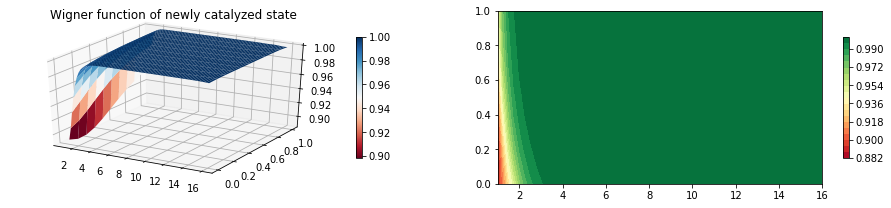

Mean photon number of starting state is 17.380504133327793
Mean photon number of end state is 33.35925702490549
fidelity of output 0.4271772027505357


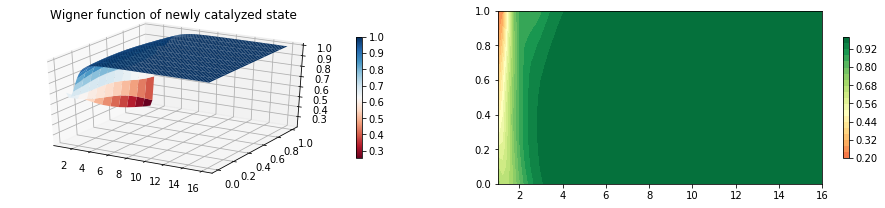

Mean photon number of starting state is 17.380504133327793
Mean photon number of end state is 33.35925702490549
fidelity of output 0.4271772027505357


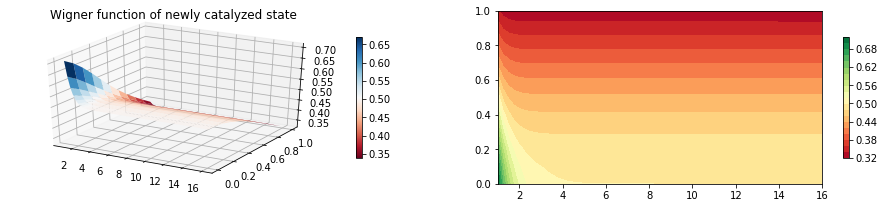

Mean photon number of starting state is 17.380504133327793
Mean photon number of end state is 33.35925702490549
fidelity of output 0.4271772027505357


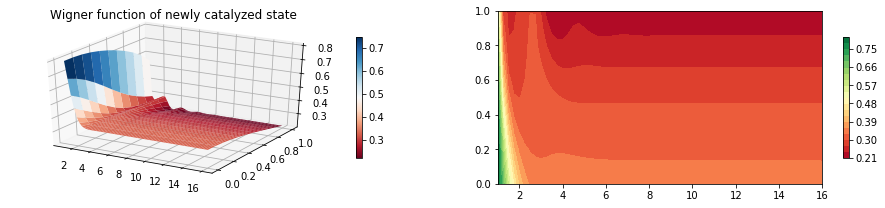

In [13]:
'''Now plot the resultant fidelities and success probabilities for the M=2 SSV state'''
fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, F, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, F, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, F_tri, 20, cmap=cm.RdYlGn,vmin=0,vmax=1)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, F_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, SuccessProb, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, SuccessProb, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, SuccessProb_tri, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, SuccessProb_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
print('fidelity of output',fid)
plt.show()

In [95]:
#test loop
my_array=np.zeros((10,12))
x=0
for k in range(10):
    x=k
    for i in range(12):
        y=i
        my_array[k,i]=x+y
    

In [103]:
my_array

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
       [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.],
       [ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]])

In [104]:
for x in range(10):
    for y in range(12):
        if my_array[x,y]>12:
            my_array[x,y]=12
            


In [105]:
my_array

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 12.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 12., 12.],
       [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 12., 12., 12.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 12., 12., 12., 12.],
       [ 6.,  7.,  8.,  9., 10., 11., 12., 12., 12., 12., 12., 12.],
       [ 7.,  8.,  9., 10., 11., 12., 12., 12., 12., 12., 12., 12.],
       [ 8.,  9., 10., 11., 12., 12., 12., 12., 12., 12., 12., 12.],
       [ 9., 10., 11., 12., 12., 12., 12., 12., 12., 12., 12., 12.]])

In [19]:
###Because the fidelity is a numerically calculated value, some of them approach 1 from above.  
###The values only differ from 1 by > 0.001, but it is enough to make the color plot look weird,
###so I just manually set these values to 1.
for x in range(11):
    for y in range(61):
        if F_tri[x,y]>1.0:
            F_tri[x,y]=1.000
            

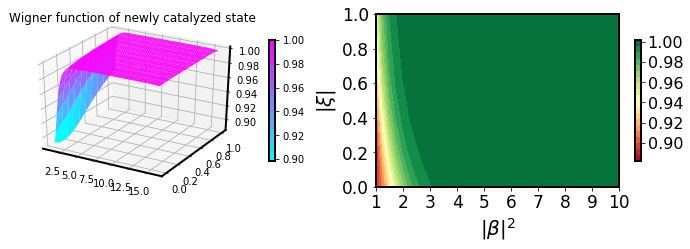

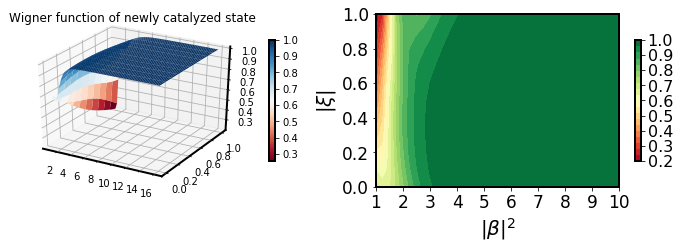

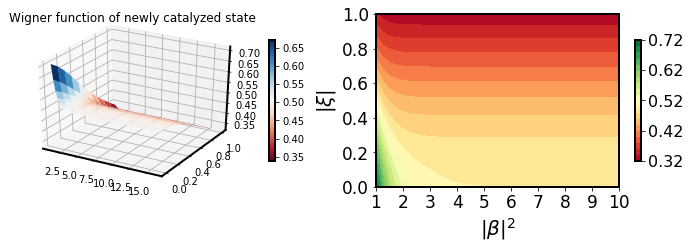

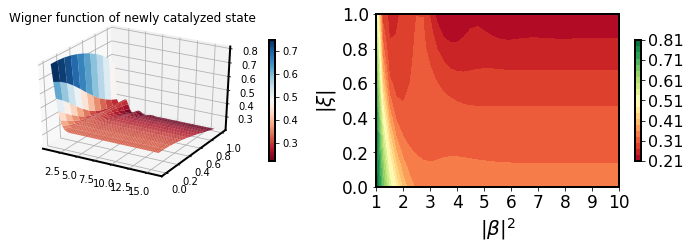

In [22]:
'''Now plot the resultant fidelities and success probabilities for the M=3 SSV state'''
from pylab import *

rc('axes', linewidth=2)
fontsize=14
fig = plt.figure(figsize=(12,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, F, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7,ticks=[.10,.25,0.35,0.88,0.90,0.92,0.94,0.96,0.98,1])
cb.ax.tick_params(labelsize=16)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel(r'$|\beta|^2$',fontsize=20,fontweight='heavy')
plt.xlim([1,10])
plt.ylabel(r'$|\xi|$',fontsize=20)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, F, rstride=1, cstride=1, cmap=cm.cool, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)


plt.title('Wigner function of newly catalyzed state')
#print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
#print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
#fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
#print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(12,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, F_tri, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7,ticks=[.10,.20,0.3,0.4,0.50,0.60,0.70,0.80,0.90,1])
cb.ax.tick_params(labelsize=16)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel(r'$|\beta|^2$',fontsize=20,fontweight='heavy')
plt.xlim([1,10])
plt.ylabel(r'$|\xi|$',fontsize=20)
plt.tick_params(axis='both', labelsize=17)

# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, F_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
ax.set_xticks([2,4,6,8,10,12,14,16])
plt.title('Wigner function of newly catalyzed state')
#print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
#print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
#fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
#print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(12,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, SuccessProb, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7,ticks=[.10,.25,0.32,0.42,0.52,0.62,0.72,0.85,0.95])
cb.ax.tick_params(labelsize=16)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel(r'$|\beta|^2$',fontsize=20,fontweight='heavy')
plt.xlim([1,10])
plt.ylabel(r'$|\xi|$',fontsize=20,rotation=90)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, SuccessProb, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
#print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
#print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
#fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
#print('fidelity of output',fid)
plt.show()

fig = plt.figure(figsize=(12,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X_ax, Y_ax, SuccessProb_tri, 20, cmap=cm.RdYlGn)
cb = fig.colorbar(p, shrink = 0.7, ticks=[0.1,.21,0.31,0.41,0.51,0.61,0.71,0.81,0.90])
cb.ax.tick_params(labelsize=16,)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel(r'$|\beta|^2$',fontsize=20,fontweight='heavy')
plt.xlim([1,10])
plt.ylabel(r'$|\xi|$',fontsize=20)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X_ax, Y_ax, SuccessProb_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
#print('Mean photon number of starting state is',(a1.dag()*a1*state).tr() )
#print('Mean photon number of end state is',(a1.dag()*a1*output).tr() )
#fid=fidelity(output,SSV_plus(sq,amp*np.sqrt(2)))
#print('fidelity of output',fid)
plt.show()